In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset,VitalSignsDataset,vital_pre_train
from model.autoencoder_v3 import *
from model.autoencoder_v3_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


In [2]:

vital_signs_train = '/home/mei/nas/docker/thesis/data/hdf/train/ts_each_patient.h5'
vital_signs_val = '/home/mei/nas/docker/thesis/data/hdf/val/ts_each_patient.h5'
vital_signs_test = '/home/mei/nas/docker/thesis/data/hdf/test/ts_each_patient.h5'

train_dataset = VitalSignsDataset(vital_signs_train)
val_dataset = VitalSignsDataset(vital_signs_val)
test_dataset = VitalSignsDataset(vital_signs_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train)

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(train_loader) 
inputs, lengths = next(small_data_iter)   

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3"

model  = PatientAutoencoder(
    n_features=154, embedding_dim=128,  n_heads=2, som_grid=(12,12)
).to(device)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")

pretrain_epochs  = 100
optimizer = optim.Adam(model.parameters(), lr=2e-3)

model1, hist_pre =pretrain_encoder_decoder(model, train_loader, device, optimizer, start=0,epochs=pretrain_epochs, save_dir=stage1_dir, patience=20)

[Pretrain] Epoch 9/100 Loss: 5.2294
[Pretrain] Epoch 19/100 Loss: 4.4057
[Pretrain] Epoch 29/100 Loss: 3.8611
[Pretrain] Epoch 39/100 Loss: 3.4210
[Pretrain] Epoch 49/100 Loss: 3.2122
[Pretrain] Epoch 59/100 Loss: 3.0794
[Pretrain] Epoch 69/100 Loss: 2.9737
[Pretrain] Epoch 79/100 Loss: 2.8900
[Pretrain] Epoch 89/100 Loss: 2.8004
[Pretrain] Epoch 99/100 Loss: 2.6721


In [8]:
stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage1/best_pretrain_model.pth'
model1 = PatientAutoencoder(
    n_features=154, embedding_dim=128,  n_heads=2, som_grid=(12,12)
).to(device)

model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [10]:
joint_epochs=100
weights = {
            'l2': 1e-4,
            'kl': 1.0,
            'diversity': 0.05,
            'smooth': 0.03,
            'neighbor': 0.02
        }

stage2_dir = os.path.join(base_dir, "stage2")
os.makedirs(stage2_dir, exist_ok=True)
optimizer = optim.Adam(model1.parameters(), lr=1e-3)
model2,hist_joint = train_joint(model1, train_loader, val_loader, device, optimizer,start=0, epochs=joint_epochs, save_dir=stage2_dir, weights=weights, patience=40)

[Joint] Epoch 10/100 Train Loss: 2.8961 | Val Loss: 3.0184
[Checkpoint] Saved: /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/checkpoint_epoch10.pth
[Joint] Epoch 20/100 Train Loss: 2.6695 | Val Loss: 2.7997
[Checkpoint] Saved: /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/checkpoint_epoch20.pth
[Joint] Epoch 30/100 Train Loss: 2.4642 | Val Loss: 2.6197
[Checkpoint] Saved: /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/checkpoint_epoch30.pth
[Joint] Epoch 40/100 Train Loss: 2.3956 | Val Loss: 2.5630
[Checkpoint] Saved: /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/checkpoint_epoch40.pth
[Joint] Epoch 50/100 Train Loss: 2.4092 | Val Loss: 2.6708
[Checkpoint] Saved: /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/checkpoint_epoch50.pth
[Joint] Epoch 60/100 Train Loss: 2.4022 | Val Loss: 2.5455
[Checkpoint] Saved: /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stag

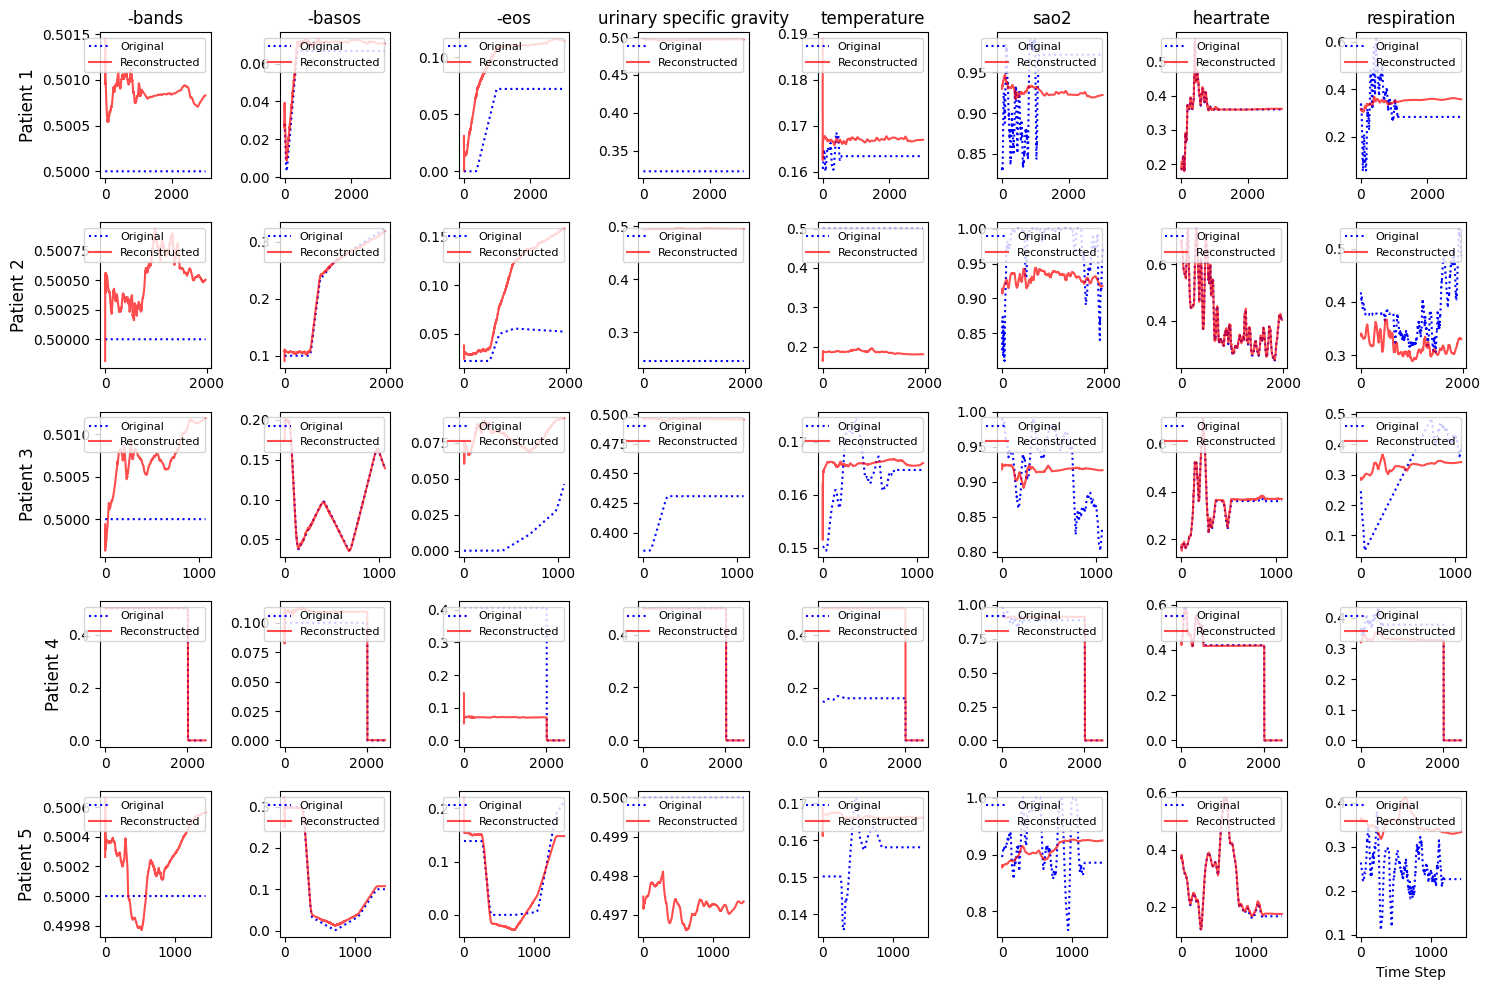

In [11]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model2, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)

In [4]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/checkpoint_epoch70.pth'
model2 = PatientAutoencoder(
    n_features=154, embedding_dim=128,  n_heads=2, som_grid=(12,12)
).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>